<div style="text-align: right"><small>pierre-henri.wuillemin@lip6.fr<br/>git clone https://gitlab.lip6.fr/phw/projetMdC2018.git
<br/>last version : <b>30/03/2018</b><br/>2018-fev</small></div>
# 3i005 -Projet 3 - Chaîne de Markov - semaine 2

Le  but de cette semaine est l'étude du comportement asymptotique d'une chaîne de Markov.

Il s'agira donc de réaliser un ensemble de codes qui permettront de calculer l'ergodicité, la convergence suivant différentes méthodes :
1. Simulation
2. Convergence de $\pi_n$
3. Convergence de $T^{(n)}$
4. Résolution directe

Ainsi que d'étudier le comportement des différentes méthodes en fonction de la taille de la châine de Markov.

## Préambule technique
Le projet prendra la forme d'un ensemble de fichiers `python` (**python3**) et un rapport. Il utilisera fortement la programmation objet. Même si ce n'est pas forcément très _pythonesque_, on s'attachera à ce sujet à définir une classe dans un fichier de même nom (sauf si spécification contraire). 

Ce notebook (`semaine2.ipynb`) est normalement directement exécutable néanmoins, si vous le préférez, vous pouvez également recopier vos codes de test dans un fichier python classique `semaine2.py`. Si vous êtes y êtes habitués ou si vous voulez vous y habituer, n'hésitez pas à utiliser des _frameworks_ de test comme [`nosetest`](http://pythontesting.net/framework/nose/nose-introduction/) , etc. Le rapport devra bien évidemment contenir un préambule technique pour expliquer vos choix et la manière d'exécuter vos codes.

> L'énoncé du projet et les sources se trouvent dans le même repository gitlab. Il suffit donc de le mettre à jour :
> ```bash
> git pull
> ```

Les codes source qui vous sont fournis sont 
- `CdM.py` qui contient une version à compléter de la classe `CdM`,
- `FeuRouge.py` qui contient une version de la classe ` FeuRouge`,
- `utils.py` qui contient quelques fonctions utilitaires.
- `CdMSampler.py` qui contient une version à compléter de la classe de simulation `CdMSampler`
- `coll*.py` qui contiennent des exemples de `Collector` (voir plus bas).

## Simulation d'une chaîne de Markov

Le premier outil pour étudier le comportement d'une chaîne de Markov est la simulation. La simulation consiste à générer une séquence d'états suivant les caractéristiques ($\pi_0$ et $P(X_t|X_{t-1})$). Cette séquence 'assez longue' permet de calculer toute statistique associée à la CdM. Nous allons donc mettre en place un framework d'échantillonnage suivant la Chaîne de Markov de manière assez générique afin de pouvoir y insérer tout code de calcul le long de la simulation.

Nous allons, pour cela, suivre (à peu près) le design pattern d'**`Observer`**. Ce design pattern consiste à indiquer qu'une classe (le **`Subject`**) est _observée_ par un ensemble d'**`Observer`** qui sont notifiés à chaque fois qu'un évènement intéressant se produit dans le **`Subject`**.

![Design Pattern Observer (from wikipedia)](images/observerDesignPattern.png)
<div style="text-align: center"><small>--Observer design pattern from wikipedia--</small></div>



Nous allons adapter ce pattern à notre cas : Le `Subject` sera notre simulateur qu'on appelera `CdMSampler` dans le fichier `CdMSampler.py`. Ce simulateur contient une liste d'objets de type `Collector` (nos `Observers`) qui ont pour but de recueillir l'information générée par le `CdMSampler`, de la traiter et, si nécessaire, de pouvoir influencer l'arrêt de la simulation.
![Collectors hiérachie](images/hierarchyCollectors.png)

Il suffira ensuite de définir des classes spécialisant `Collector` et effectuant les calculs ou les actions attendues. Le code des collectors `CollProgresser`, `CollTimeOut` et `CollSingleStateCounter` vous est fourni pour exemple.

### Question 9

Compléter la classe CdMSampler. Il faut en particulier :

1) Fournir le corps de la méthode de classe `CdMSampler.draw_from_distribution(distribution)`

In [1]:
from CdMSampler import CdMSampler
nbrA=0
nbr_iteration=10000
for i in range(nbr_iteration):
    # draw_from_distribution est une méthode de classe : pas besoin de créer d'objet MdCSampler.
    if CdMSampler.draw_from_distribution({"A":0.4,"B":0.6})=="A":
        nbrA+=1
print("Probabilité estimé de A : {}".format(nbrA/nbr_iteration))

Probabilité estimé de A : 0.398


2) Fournir le corps de la méthode `CdMSampler.run(max_iter)`. Elle appellera les `notify_*` pour communiquer avec les `collectors` et doit :
> a. initialiser les `collectors` et la génération
>
> b. générer aléatoirement la séquence d'états en notifiant à chaque fois les `collecters` et en s'arrêtant si un `collector` le demande ou si le nombre d'itérations maximum est atteint. 
>
> c. finaliser les `collectors`
>
> d. retourner le résultat calcule par `collect_results()`

Par exemple :

In [2]:
from CdMSampler import CdMSampler
from MouseInMaze import MouseInMaze
m=MouseInMaze()

s=CdMSampler(m)
print("- Sampler sans collector")
print(s.run(10))

print("\n- Sampler avec CollProgresser (voir CollProgresser.py)")
from CollProgresser import CollProgresser
s.add_collector(CollProgresser(3,9))
print(s.run(67))

print("\n - Sampler avec CollProgresser et CollSinleStateCounter (voir CollSingleStateCounter.py)")
from CollSingleStateCounter import CollSingleStateCounter
s.add_collector(CollSingleStateCounter(m.get_states()[1]))
s.add_collector(CollSingleStateCounter(m.get_states()[4]))
print(s.run(150))

print("\n - Sampler avec CollProgresser, CollSinleStateCounter et ColTimeOut (voir CollTimeOut.py)")
from CollTimeOut import CollTimeOut
s.add_collector(CollTimeOut(1)) # time out de 1 seconde
print(s.run(150000000000))

- Sampler sans collector
{'nbr_iterations': 10}

- Sampler avec CollProgresser (voir CollProgresser.py)
run(67): ..#..#..#..#..#..#..#. <-- stop with 67 iterations
{'nbr_iterations': 67}

 - Sampler avec CollProgresser et CollSinleStateCounter (voir CollSingleStateCounter.py)
run(150): ..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#.. <-- stop with 150 iterations
État <2> visité 3 fois
État <5> visité 143 fois
{'nbr_iterations': 150, 'count': {2: 3, 5: 143}}

 - Sampler avec CollProgresser, CollSinleStateCounter et ColTimeOut (voir CollTimeOut.py)
run(150000000000): ..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#..#

## Collectors

Les `collectors` permettent d'effectuer des actions et des calculs le long de l'exécution de la simulation. Le deisgn pattern `Observer` permet de les cumuler. Par exemple, voici le code d'un `Collector` très simple ne faisant qu'afficher les états générés :

In [3]:
from Collector import Collector
from CdMSampler import CdMSampler
from MouseInMaze import MouseInMaze

class BasicCollector(Collector):
  def __init__(self):
    pass

  def initialize(self, cdm, max_iter):
    print("[debut]", end="", flush=True)

  def receive(self, cdm, iter, state):
    if iter==1:
        print(state, end="", flush=True)
    else:
        print("-> "+str(state), end="", flush=True)
    return False # True pour arrêter la génération

  def finalize(self, cdm, iteration):
    print("[fin : {}]".format(iteration))

  def get_results(self, cdm):
    return None

m=MouseInMaze()
sampler=CdMSampler(m)
sampler.add_collector(BasicCollector())
sampler.run(20)

[debut]2-> 1-> 2-> 4-> 3-> 5-> 5-> 5-> 5-> 5-> 5-> 5-> 5-> 5-> 5-> 5-> 5-> 5-> 5-> 5[fin : 20]


{'nbr_iterations': 20}

La cellule ci-dessus exécutée plusieurs fois, donnera des trajectoires différentes de la chaîne de Markov `MouseInMaze`, toujours de taille 20.

### Question 10 
Écrire dans `CollDistribution.py` une classe `CollDistribution` qui permet de calculer la probabilité de chaque état et qui arrête la simulation à la convergence. Pour tester la convergence, il s'agit de faire la différence entre 2 distributions de probabilité. On utilisera par exemple, la norme max. Le critère d'arrêt se fera par rapport à un argument `epsilon`.

Par ailleurs, un autre argument `pas` indiquera de présenter la distribution courante toutes les `pas` itérations (en commençant par afficher l'itération initiale). Si `pas` est nul, il n'y aura pas d'affichage en cours de simulation.

4 premières itérations de Monobestiole


{'erreur': 0.25,
 'nbr_iterations': 4,
 'proba': {'12': 0.25, '13': 0.25, '14': 0.25, '15': 0.25}}

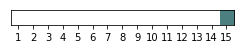

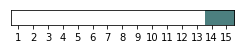

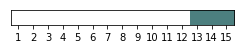

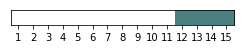

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from CdMSampler import CdMSampler
from MonoBestiole import MonoBestiole
from CollGetDistribution import CollGetDistribution

print("4 premières itérations de Monobestiole")
m=MonoBestiole(15,0.5,0.5)
sampler=CdMSampler(m)
sampler.add_collector(CollGetDistribution(epsilon=1e-5,pas=1))
sampler.run(4)

Itérations de monobestiole jusque convergence
Durée : 4.622997283935547s


{'duration': 4.622997283935547,
 'erreur': 6.58826588262329e-06,
 'nbr_iterations': 100000,
 'proba': {'1': 0.34118,
  '10': 0.00652,
  '11': 0.00442,
  '12': 0.00317,
  '13': 0.00227,
  '14': 0.00172,
  '15': 0.00138,
  '2': 0.22452,
  '3': 0.14824,
  '4': 0.09935,
  '5': 0.06728,
  '6': 0.04416,
  '7': 0.02792,
  '8': 0.0174,
  '9': 0.01047}}

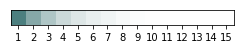

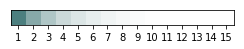

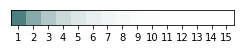

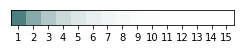

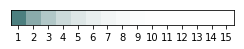

In [5]:
from CollTimeOut import CollTimeOut

print("Itérations de monobestiole jusque convergence")
m=MonoBestiole(15,0.4,0.6)
sampler=CdMSampler(m)
sampler.add_collector(CollGetDistribution(epsilon=1e-5,pas=20000))
sampler.add_collector(CollTimeOut(10)) # time out de 10 seconde
sampler.run(100000)

## Convergence et ergodicité
Une Chaîne de Markov est dite convergente si le processus de simulation ci-dessus converge vers une distribution $\pi^*$. 

Dans ce cadre, une propriété importante des CdM est l'**ergodicité**. Une CdM ergodique converge, vers la même distribution $\pi^*$ quelque soit la distribution initiale $\pi_0$.

Pour une CdM finie, ergodicité est équivalent à irréductible+apériodique.

### Question 11
Ajouter une méthode dans `CdM.py` une méthode `CdM.is_ergodic()` qui vérifie si une chaîne de Markov est ergodique.

### Question 12 
Vérifier les propriétés d'ergodicité en analysant les résultats de simulation pour les Cdm 
:
> 1. MouseInMaze
> 2. MonoBestiole
> 3. PeriodiCdM dont le code se trouve dans `PeriodicCdm.py`

## Calcul de $\pi*$
En notant $\pi_n$ la distribution de la CdM à l'état $n$, on se souvient qu'on a :
$$\pi_{n+1}=\pi_t \cdot M = \pi_0 \cdot M^n$$
où $M$ est la matrice de transition de la CdM.


Lorsqu'une chaîne de Markov est irréductible, outre la simulation, on a donc plusieurs méthodes qui permettent de calculer $\pi$ :

1. Convergence de $\pi_n$ : en itérant l'équation $\pi_{n+1}=\pi_n\cdot M$ et en s'arrêtant quand la distance entre $\pi_n$ et $\pi_{n+1}$ est assez faible.

2. Convergence de $M^n$ : La suite des puissances de $M$ converge (vers quoi ?).

3. Point fixe : $\pi^*$ est un point fixe et vérifié donc $$\pi^*=\pi^*\cdot M$$ $\pi^*$ est donc un vecteur propre de $M$ pour la valeur propre $1$. 

### Question 13
Écrire une classe `CdMConvergence` dans `CdMConvergence.py` qui calcule pour une CdM ergodique la distribution $\pi^*$ selon les 4 méthodes en relevant pour chacune la valeur calculée pour $\pi^*$, le nombre d'itérations nécessaires (si c'est un processus itératif), le temps nécessaire.